# CDF Thresholding

Fit a cdf to a prior, and then threshold behind that

Andre Telfer

## Table of Contents
[toc]

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os 
import re
import pickle
import shutil
from functools import partial
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

# Used for storing/accessing data
output_dir = 'cdf_thresholding_data'
pickle_file = 'frames'

Running OpenCV sections:

In [2]:
import cv2

## Demo Code
This code was used to test features in a controlled environment

### Demo Histrogram

<BarContainer object of 998 artists>

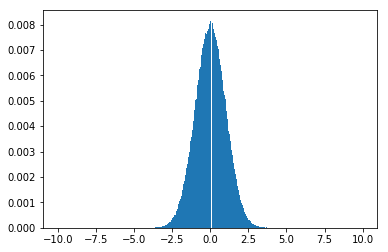

In [3]:
# Create data with a normal distribution
x = np.random.normal(0, 1, size=1000000)

# Create bins
start, stop, count = -10, 10, 1000
bins = np.linspace(start,stop, count)
assign_bins = np.digitize(x, bins)

# Sum bins
bin_counts = np.bincount(assign_bins, minlength=bins.shape[0]-2)

# Normalize 
bin_counts = bin_counts / np.sum(bin_counts)

# Plot
plt.bar(x=bins[:-2], height=bin_counts, width=(start-stop)/count)

### Demo Cumulative Threshold

<BarContainer object of 998 artists>

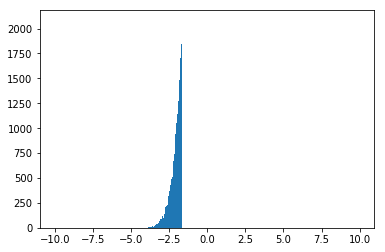

In [4]:
target_p = 0.05

# Get cumulative sum of normalized bins
cumsum_bins = np.cumsum(bin_counts)

# Find bins where cumsum < 0.05
bins_le = bins[:-2][cumsum_bins < target_p]

# Get the threshold as the last bin
threshold = bins_le[-1]

# Plot
y = x.copy() 
y_assigned_bins = np.digitize(y[y < threshold], bins)
y_bin_counts = np.bincount(y_assigned_bins, minlength=bins.shape[0]-2)
plt.bar(bins[:-2], height=y_bin_counts, width=(start-stop)/count)

### Demo Split Array
We need to do this as the complete numpy array of a 100x1920x1080 is too large for this computer when doing computations

In [5]:
x = np.random.normal(size=(1000)).reshape(10,10,10)

# Split down 1st axis
x_split1 = np.split(x, x.shape[1]/2, axis=1)

# Rejoin
y = np.concatenate(x_split1, axis=1)

# Check if rejoined is the same as original
print(np.equal(x, y).all())

# Clean up
del x, y, x_split1

True


## Build Models

Using the first n frames, find the cdf of intensity per pixel

### Open Video File

In [6]:
video_file = os.path.join(os.getcwd(), '../video_fish_A.avi')
cap = cv2.VideoCapture(video_file)
assert cap.isOpened(), "Error opening video file"

### Fetch N Frames

In [7]:
%%time
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Randomly select n frames and store them in 'frames'
n = 100
frame_samples = list(np.random.choice(list(range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))), size=n))
frames = np.zeros(shape=(n, frame_height, frame_width))
sample_index = 0
for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    
    # Check if the frame was selected as one of the sample frames
    if i in frame_samples:
        grey =  cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames[sample_index] = grey
        sample_index += 1
    
print("Frame Shape: {}".format(grey.shape))

Frame Shape: (1080, 1920)
CPU times: user 3min 22s, sys: 3.28 s, total: 3min 26s
Wall time: 3min 26s


### Export Data
Computation's are breaking the docker instance due to memory problems which can be better managed directly by the host computer

In [9]:
%%time 

# Split array to make computations easier
split_indices = np.arange(start=50, stop=frames.shape[1], step=50)
split_frames = np.split(frames, split_indices, axis=1)
del frames
    
# Write the frames
if not os.path.exists(output_dir): 
    os.mkdir(output_dir)
else:
    shutil.rmtree(output_dir)
    os.mkdir(output_dir)
    
for i in range(len(split_frames)):
    print('Stepping...')
    file_path = os.path.join(output_dir, '{}{}.p'.format(pickle_file, i))
    with open(file_path, 'wb') as fp:
        pickle.dump(split_frames[i], fp)
        
print('Done')

Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Stepping...
Done
CPU times: user 3.18 s, sys: 7.75 s, total: 10.9 s
Wall time: 27.6 s


### Find $x_{thr}$ 

Per pixel, find an intensity threshold  $x_{thr}$ such that $P(X\le x_{thr}) = 0.05$

Grey pixel intensities are in the range of $[0,255]$ 

In [5]:
# bins 
bins = np.arange(0, 256, 1)

# get files in folder and sort them
file_pattern = pickle_file + "(\d+)\.p"
files = os.listdir(output_dir)
files = list(filter(lambda x: re.search(file_pattern, x), files))
files = sorted(files, key=lambda x: int(re.search(file_pattern, x).groups()[0]))

In [6]:
%%time 
# output arrays
outputs = {}
for file_path in files:
    print('Stepping... ')
    
    # load the data file
    with open(os.path.join(output_dir, file_path), 'rb') as fp:
        a = pickle.load(fp)
        
    # count intensities
    counts = np.apply_along_axis(
        func1d = partial(np.bincount, minlength=257), 
        axis = 0,
        arr = a.astype(np.int64)
    )
    
    # normalize counts to get probabilities of each intensity
    normalized = counts / np.sum(counts,axis=0)
    
    # get the cdf
    cdf = np.cumsum(normalized, axis=0)
    
    for threshold in [0.05, 0.01, 0.005]:
        # For each pixel, find the last position where the cdf is less than the threshold
        threshold_values = np.zeros(shape=(a.shape[1], a.shape[2]))
        
        for i in range(cdf.shape[1]):
            for j in range(cdf.shape[2]):
                # find the last index with cdf less than threhsold
                last_indices = np.argwhere(cdf[:,i,j] < threshold)

                # if no indices have a cdf below threshold, then set the threshold value to -1
                if last_indices.shape[0] == 0:
                    threshold_values[i,j] = -1
                else:
                     # get the intensity threshold coresponeding to the last index
                    last_index = last_indices[-1]
                    threshold_values[i,j] = bins[last_index]
        
        if threshold in outputs:
            outputs[threshold].append(threshold_values)
        else:
            outputs[threshold] = [threshold_values]

print('Done')

Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Stepping... 
Done
Wall time: 1min 25s


In [7]:
for threshold in outputs:
    thresholds = np.concatenate(outputs[threshold], axis=0)
    file_path = os.path.join(output_dir, 'thresholds{}.p'.format(
        str(threshold).split('.')[-1])
    )
    with open(file_path, 'wb') as fp:
        pickle.dump(thresholds, fp)

## Results 
Apply thresholds to random frames to attain results

In [3]:
file_path = os.path.join(output_dir, 'thresholds05.p')
with open(file_path, 'rb') as fp:
    thresholds_05 = pickle.load(fp)
    
file_path = os.path.join(output_dir, 'thresholds01.p')
with open(file_path, 'rb') as fp:
    thresholds_01 = pickle.load(fp)

file_path = os.path.join(output_dir, 'thresholds005.p')
with open(file_path, 'rb') as fp:
    thresholds_005 = pickle.load(fp)

Frame Shape: (1080, 1920)
CPU times: user 4min 44s, sys: 13.5 s, total: 4min 57s
Wall time: 4min 9s


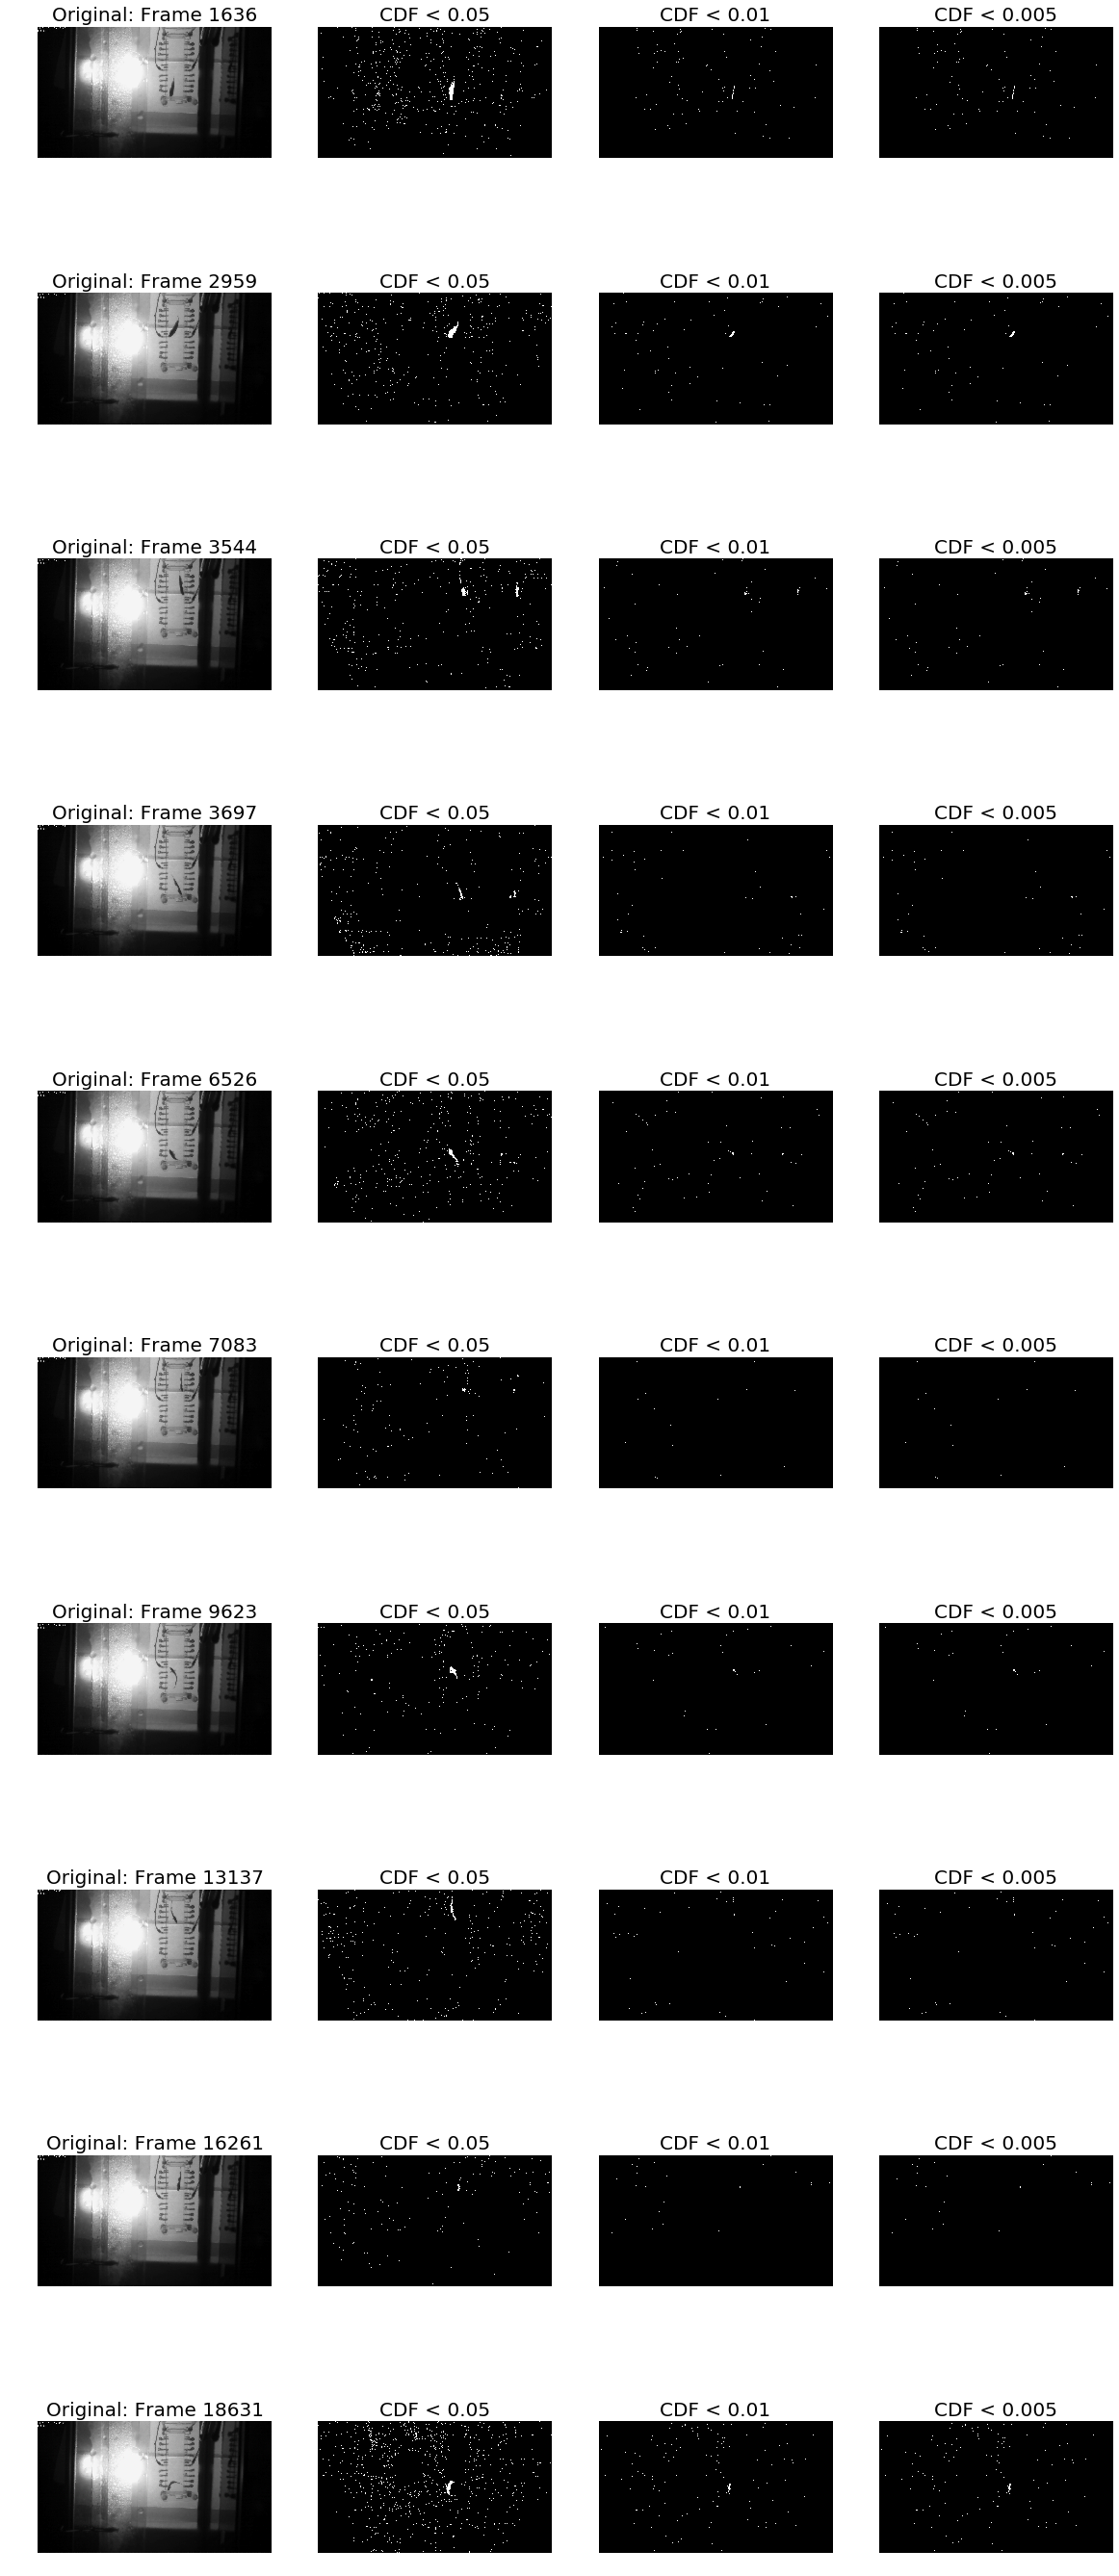

In [4]:
%%time

video_file = os.path.join(os.getcwd(), '../video_fish_A.avi')
cap = cv2.VideoCapture(video_file)
assert cap.isOpened(), "Error opening video file"

rows, cols = 10, 4

# Skip the first n frames that were used for training
frame_samples = list(np.random.choice(list(range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))), size=rows))

fig = plt.figure(figsize=(20,5*rows))
# fig.suptitle("Frames", fontsize=20)

row = 0
for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    # Fetch the frame
    ret, frame = cap.read()
    grey =  cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    if i in frame_samples:
        # Plot
        plt.subplot(rows, cols, row*cols + 1)
        plt.axis('off')
        plt.title('Original: Frame {}'.format(i), fontsize=20)
        plt.imshow(grey, 'gray')

        # Apply the threshold
        out = np.less_equal(grey, thresholds_05).astype(np.uint8)
        plt.subplot(rows, cols, row*cols + 2)
        plt.axis('off')
        plt.title('CDF < 0.05', fontsize=20)
        plt.imshow(out, 'gray')

        # Apply the threshold
        out = np.less_equal(grey, thresholds_01).astype(np.uint8)
        plt.subplot(rows, cols, row*cols + 3)
        plt.axis('off')
        plt.title('CDF < 0.01', fontsize=20)
        plt.imshow(out, 'gray')

        # Apply the threshold
        out = np.less_equal(grey, thresholds_005).astype(np.uint8)
        plt.subplot(rows, cols, row*cols + 4)
        plt.axis('off')
        plt.title('CDF < 0.005', fontsize=20)
        plt.imshow(out, 'gray')
        
        row += 1
    
print("Frame Shape: {}".format(grey.shape))

## Observations
- Some frames perform quite well (ex. Frame 1071), some are quite noisy (ex. Frame 15226), and some barely find the fish at all (ex. Frame 4094)



### Histograms of Pixel Values 
Randomly selects pixels and finds their values for every frame in the video

In [6]:
%%time

# Reopen video
video_file = os.path.join(os.getcwd(), '../video_fish_A.avi')
cap = cv2.VideoCapture(video_file)
assert cap.isOpened(), "Error opening video file"

# Number of plots to make
rows, cols = 6, 4

# Select random coordinates for pixels
n = rows * cols
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
rx = np.random.choice(a=np.arange(0,frame_height,1), size=n)
ry = np.random.choice(a=np.arange(0,frame_width,1), size=n)
print("Pixels: {}".format(list(zip(rx, ry))))

# Loop through video to get pixel values
data = {}
for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    if not ret: continue
    grey =  cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Save the pixels
    for col, row in zip(rx, ry):
        if (col,row) in data:
            data[(col,row)].append(grey[col,row])
        else:
            data[(col,row)] = [grey[col,row]]

Pixels: [(193, 1555), (566, 1334), (704, 422), (213, 1423), (600, 1540), (507, 633), (563, 1503), (358, 1871), (821, 245), (545, 551), (617, 1385), (716, 1651), (1044, 966), (898, 500), (575, 173), (177, 1494), (877, 1433), (1004, 313), (667, 467), (789, 713), (78, 314), (376, 651), (746, 1017), (532, 1263)]
CPU times: user 4min 34s, sys: 13 s, total: 4min 47s
Wall time: 4min 1s


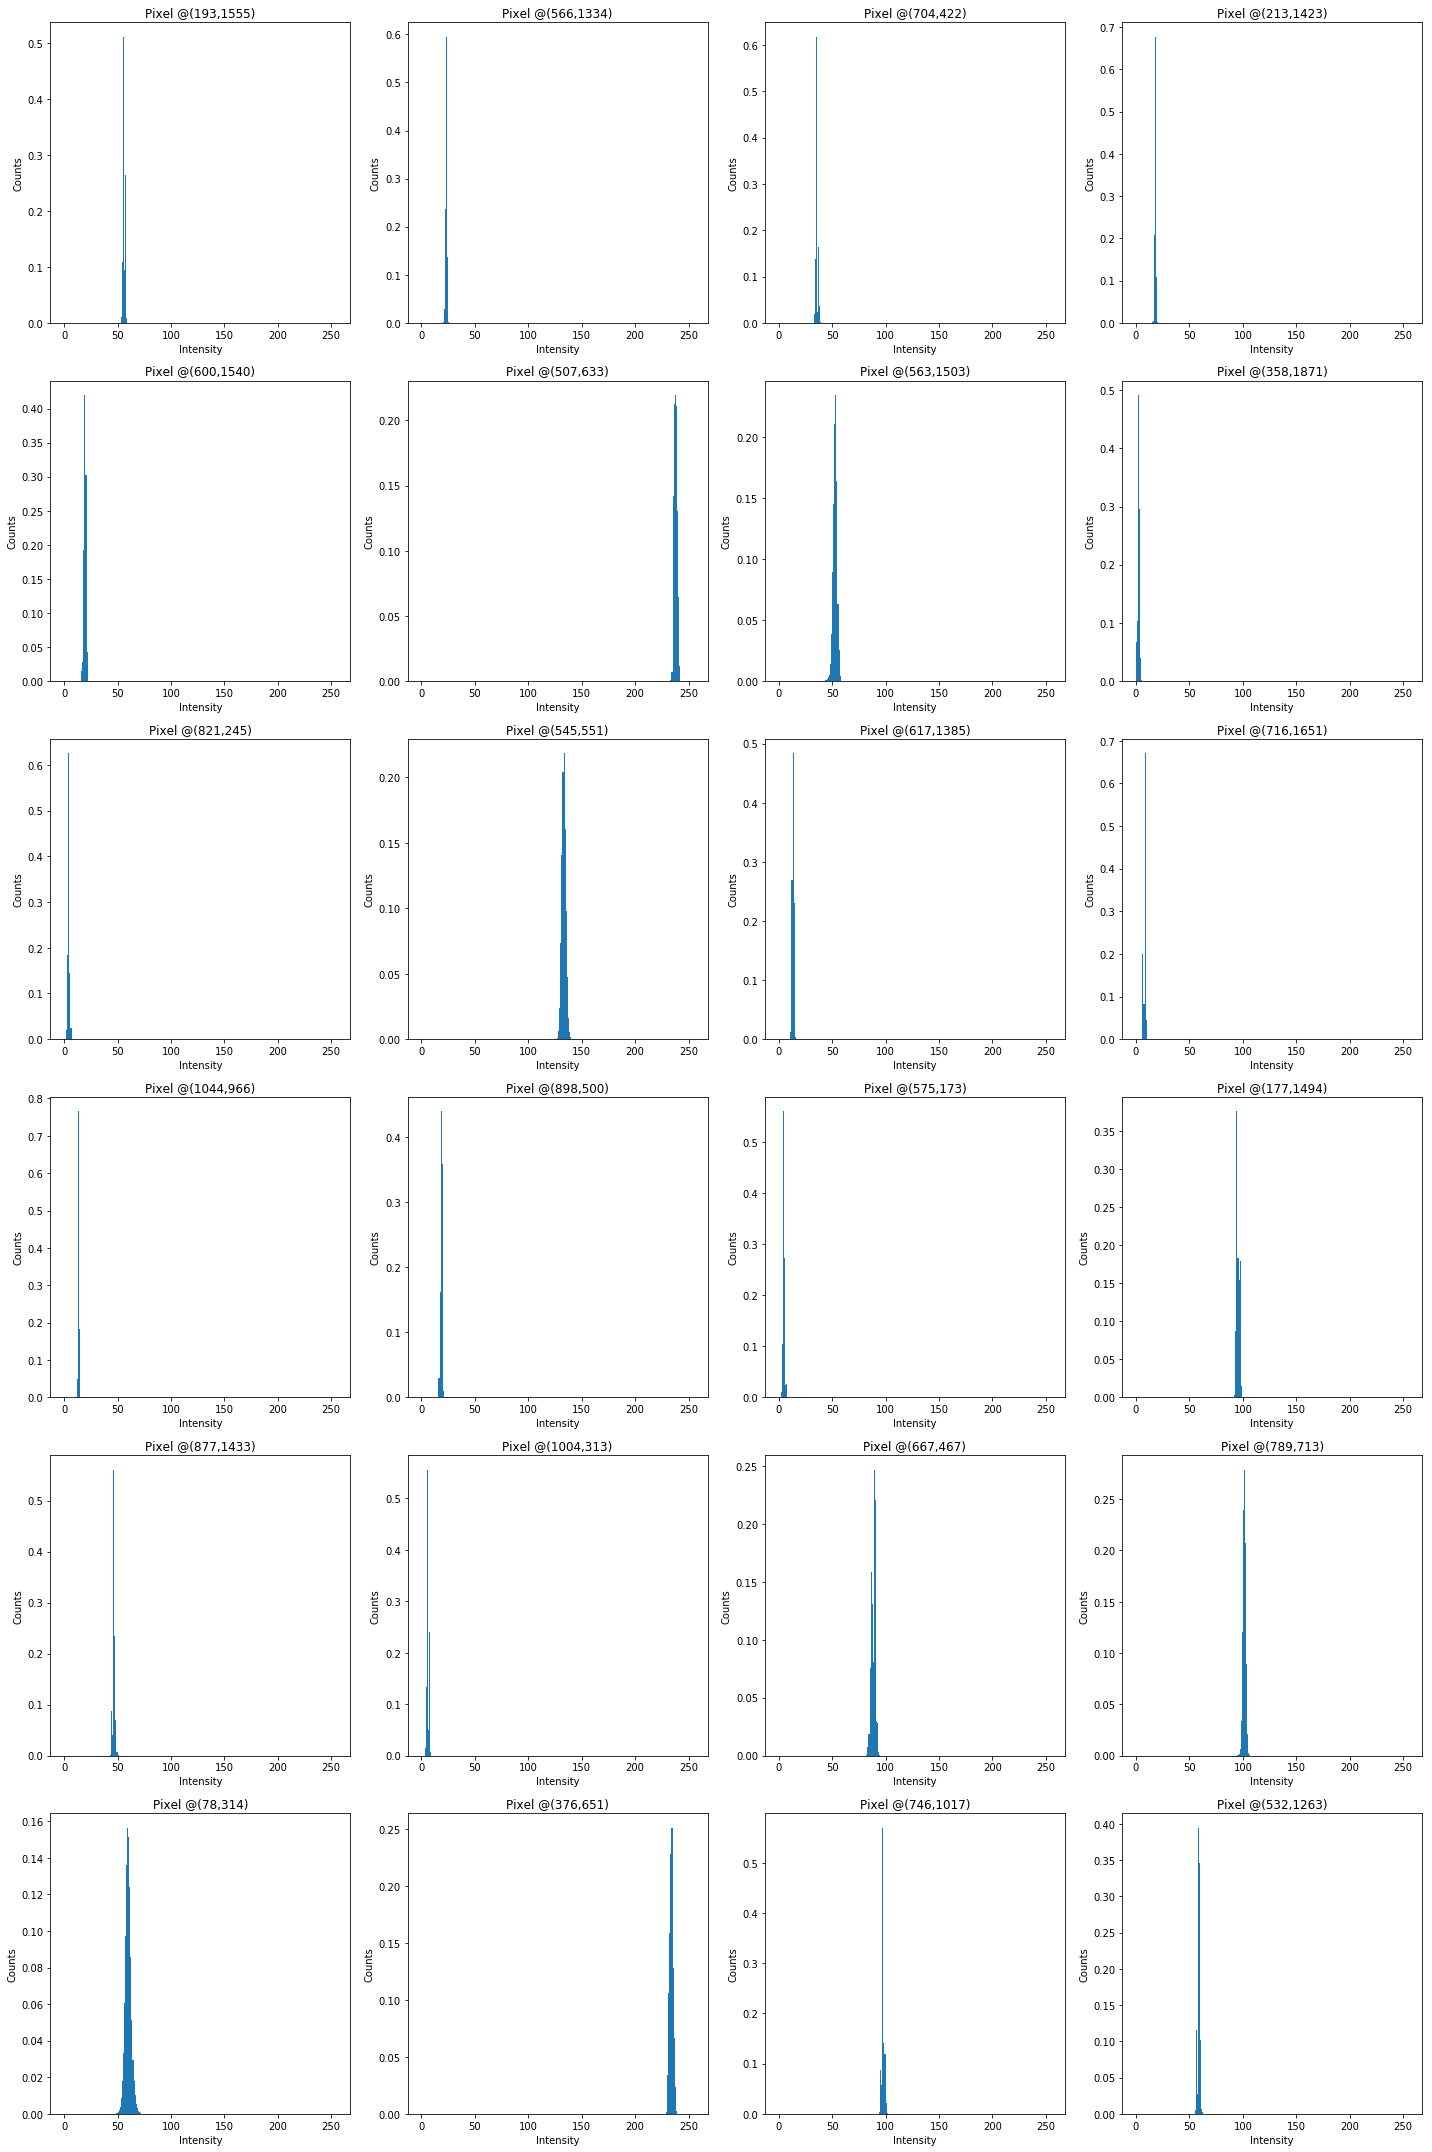

In [20]:
# Plot their histograms
fig, axes = plt.subplots(rows, cols, figsize=(20, rows*5))
bins = np.arange(0, 256, 1)
index = 0
for col, row in zip(rx, ry):
    plt.subplot(rows, cols, index+1)
    plt.hist(data[(col,row)], bins, density=True)
    plt.title("Pixel @({},{})".format(col, row))
    plt.ylabel("Counts")
    plt.xlabel("Intensity")
    index += 1

fig.tight_layout()

### Threshold Surface and Contour Plot
Surface plot of the threshold values in different areas of the frame
- Areas with low thresholds are likely to be less sensitive to the fish, which is also dark

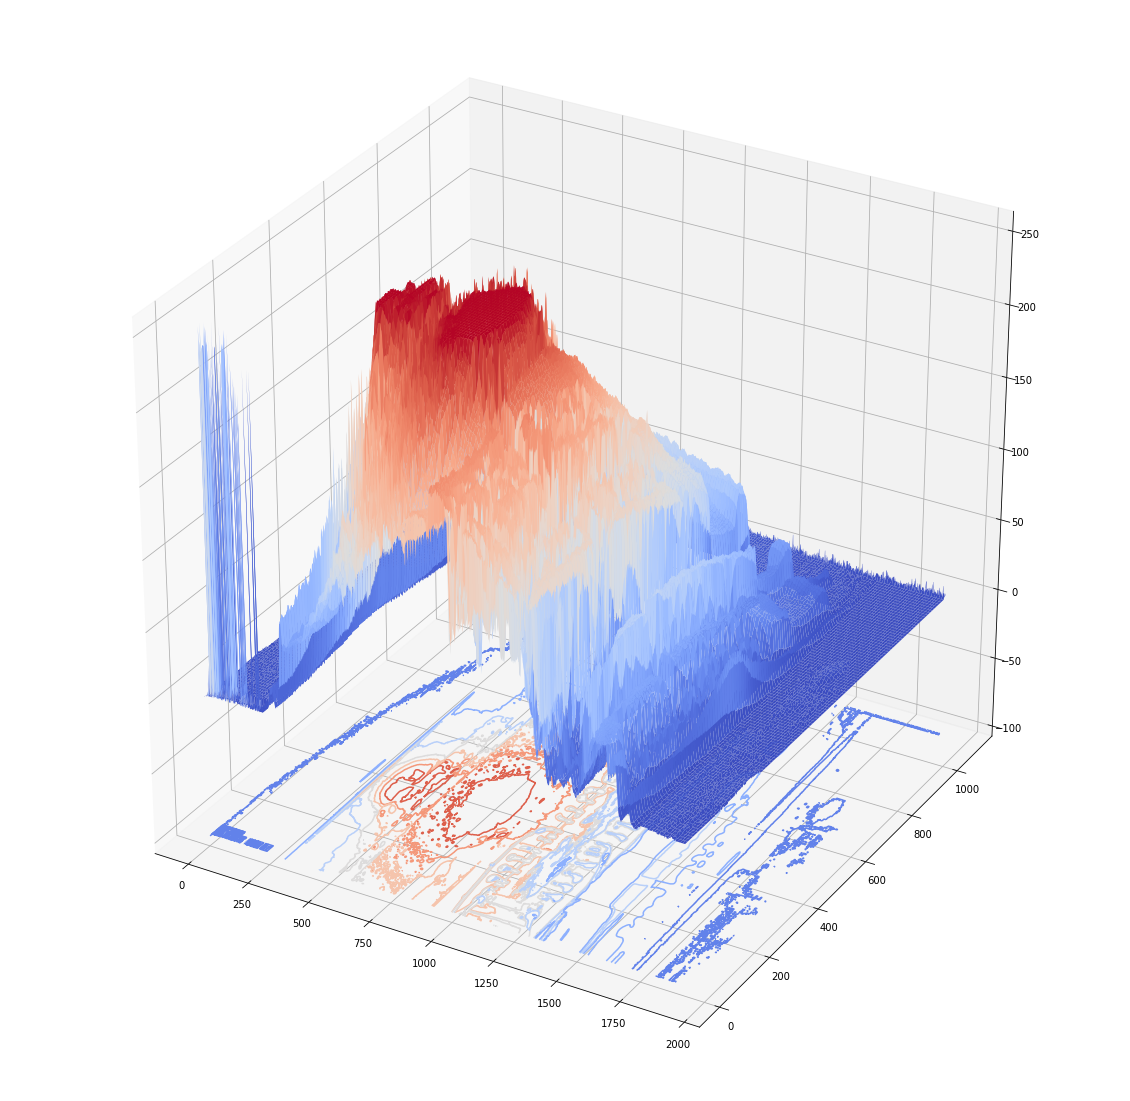

In [8]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(np.arange(0,frame_width,1), np.arange(0,frame_height,1), sparse=False)

ax.plot_surface(X, Y, Z=thresholds_05, cmap=cm.coolwarm, rstride=10, cstride=10)
cset = ax.contour(X, Y, Z=thresholds_05, zdir='z', offset=-100, cmap=cm.coolwarm)
ax.set_zlim(-100, 256)
plt.show()